# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [3]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [4]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [5]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [6]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [7]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [8]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [9]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [11]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [12]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]])

In [13]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [14]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [15]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [16]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [17]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

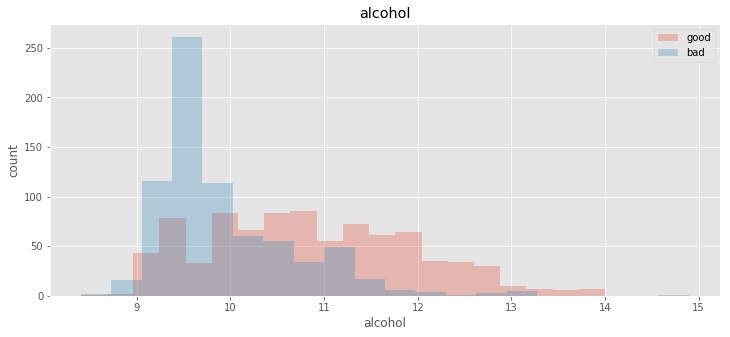

In [18]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [19]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [21]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [22]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [23]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [24]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [25]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [26]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [96]:
from sklearn.base import ClusterMixin, BaseEstimator
import operator
import scipy.spatial.distance as ssd
from sklearn.metrics.pairwise import euclidean_distances

def distance(x,y,metric):
    return ssd.pdist((x,y),metric)[0]

def start_centroids(self,X):
    if self.init=='random':
        indexes=np.random.choice(X.shape[0],self.k)
        self.centroids=np.array([X[i] for i in indexes])
    if self.init=='++': #k-means ++, просто по другому задаем центроиды
        self.centroids[0]=X[np.random.choice(X.shape[0])]
        for i in xrange(1,self.k):
            D=np.min(euclidean_distances(X,self.centroids[0:i]), axis=1)
            prob=D/D.sum()
            self.centroids[i]=X[np.random.choice(X.shape[0], p=prob)] 
    return self.centroids
 

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init=init

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k,X.shape[1]))
        
        ## Your Code Here
        # ...
        eps=0.001
        summ=1.0
        iterator=0
        dist=np.zeros(self.k)
        self.centroids=start_centroids(self,X)
        while summ>eps and iterator<self.max_iter:
            summ=0.0
            self.labels=np.argmin(euclidean_distances(X,self.centroids), axis=1)
            for i in xrange(self.k):
                M=X[self.labels==i]
                if len(M)!=0:
                    summ=summ+distance(self.centroids[i],np.mean(M,axis=0),self.metric)
                    self.centroids[i]=np.mean(M,axis=0) 
                else:
                    summ=summ 
                    self.centroids[i]=self.centroids[i]        
            iterator=iterator+1
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """

class MiniBatchKMeans(Kmeans):
    def __init__(self, k=8, metric='euclidean', max_iter=1000, random_state=None, init='random', batch_size=10):
        Kmeans.__init__ (self, k, metric, max_iter, random_state, init)
        self.batch_size=batch_size
    def fit(self,X,y=None):    
        np.random.seed(self.random_state)
        size_x=X.shape[1]
        self.centroids = np.empty((self.k,size_x))
        self.centroids=start_centroids(self,X)
        v=np.ones(self.k)
        #self.labels = np.empty(X.shape[0])
        eps=0.01
        #eps=0.001*self.batch_size/X.shape[0]
        iterator=0
        summ=1.0
       # while summ>eps and iterator<self.max_iter:
        while iterator<self.max_iter:
            iterator=iterator+1
            M=X[np.random.randint(X.shape[0], size=self.batch_size)]
            d=np.argmin(euclidean_distances(M,self.centroids),axis=1)
            centroids_old=np.copy(self.centroids)
            for i in xrange(self.k):
                new_centroid= (self.centroids[i])*(v[i])+M[d == i].sum(axis=0)
                v[i] += (d == i).sum()
                self.centroids [i] = new_centroid/(v[i])
            #summ=np.trace(euclidean_distances(centroids_old,self.centroids))
        self.labels=np.argmin(euclidean_distances(X,self.centroids),axis=1)
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [28]:
from sklearn.datasets import make_blobs

In [29]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

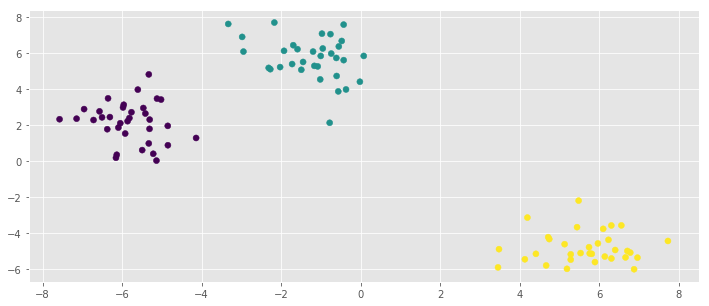

In [30]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

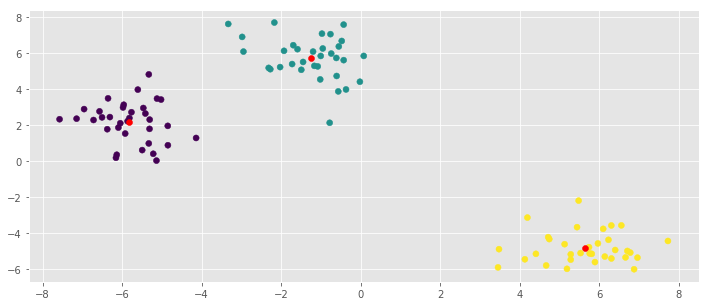

In [31]:
## Работоспособность KMeans
modelK = Kmeans(3)
modelK.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(modelK.centroids[:,0],modelK.centroids[:,1],c='red') 

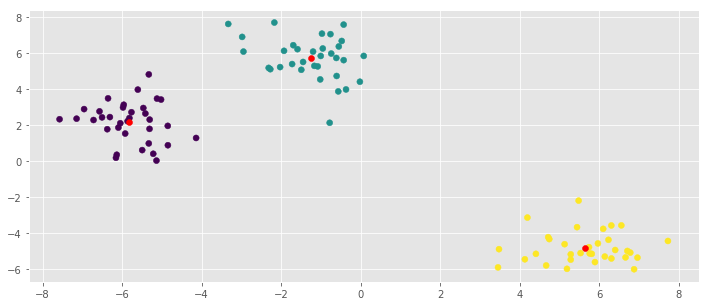

In [32]:
## Работоспособность KMeans++
modelKpp = Kmeans(3, 'euclidean', 1000, None, '++')
modelKpp.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(modelKpp.centroids[:,0],modelKpp.centroids[:,1],c='red')

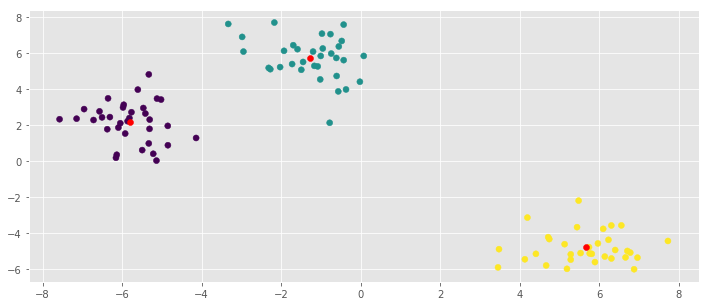

In [74]:
## Работоспособность KMeans с MiniBatchKMeans
modelMB = MiniBatchKMeans(3, 'euclidean', 1000, None, 'random')
modelMB.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(modelMB.centroids[:,0],modelMB.centroids[:,1],c='red')

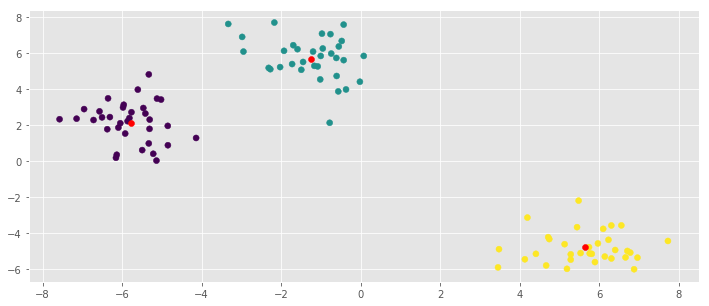

In [75]:
## Работоспособность KMeans++ с MiniBatchKMeans
modelMBpp = MiniBatchKMeans(3, 'euclidean', 1000, None, '++')
modelMBpp.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(modelMBpp.centroids[:,0],modelMBpp.centroids[:,1],c='red')

In [144]:
## Время выполнения алгоритма KMeans
model=Kmeans(k=3,init='random')
measure_k = list()
for i in xrange(1000,10000,1000):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
                        center_box=(-10, 10), shuffle=False, random_state=1234) 
    res = %timeit -o -q -n 1 -r 100 model.fit(X)
    measure_k.append(res.best)
    print "size={0}, time = {1}".format(i, measure_k[i/1000-1])

size=1000, time = 0.00330686569214
size=2000, time = 0.00343799591064
size=3000, time = 0.00588297843933
size=4000, time = 0.00672698020935
size=5000, time = 0.00533103942871
size=6000, time = 0.00844693183899
size=7000, time = 0.00931096076965
size=8000, time = 0.0102500915527
size=9000, time = 0.0111382007599


In [145]:
## Время выполнения алгоритма KMeans++
model=Kmeans(k=3,init='++')
measure_kpp = list()
for i in xrange(1000,10000,1000):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
                        center_box=(-10, 10), shuffle=False, random_state=1234) 
    res = %timeit -o -q -n 1 -r 100 model.fit(X)
    measure_kpp.append(res.best)
    print "size={0}, time = {1}".format(i, measure_kpp[i/1000-1])

size=1000, time = 0.00404715538025
size=2000, time = 0.00490403175354
size=3000, time = 0.00587391853333
size=4000, time = 0.00873994827271
size=5000, time = 0.00742506980896
size=6000, time = 0.0109791755676
size=7000, time = 0.012069940567
size=8000, time = 0.013237953186
size=9000, time = 0.0143570899963


In [146]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
model=MiniBatchKMeans(k=3,init='random',max_iter=100)
measure_mb = list()
for i in xrange(1000,10000,1000):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
                        center_box=(-10, 10), shuffle=False, random_state=1234) 
    res = %timeit -o -q -n 1 -r 5 model.fit(X)
    measure_mb.append(res.best)
    print "size={0}, time = {1}".format(i, measure_mb[i/1000-1])

size=1000, time = 0.0700199604034
size=2000, time = 0.0673508644104
size=3000, time = 0.0739569664001
size=4000, time = 0.0817339420319
size=5000, time = 0.0682699680328
size=6000, time = 0.0690970420837
size=7000, time = 0.0681581497192
size=8000, time = 0.0821528434753
size=9000, time = 0.0811541080475


In [147]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans
model=MiniBatchKMeans(k=3,init='++',max_iter=100)
measure_mbpp = list()
for i in xrange(1000,10000,1000):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
                        center_box=(-10, 10), shuffle=False, random_state=1234) 
    res = %timeit -o -q -n 1 -r 5 model.fit(X)
    measure_mbpp.append(res.best)
    print "size={0}, time = {1}".format(i, measure_mbpp[i/1000-1])

size=1000, time = 0.0770318508148
size=2000, time = 0.0688600540161
size=3000, time = 0.0746519565582
size=4000, time = 0.0696699619293
size=5000, time = 0.0791921615601
size=6000, time = 0.0717151165009
size=7000, time = 0.0709550380707
size=8000, time = 0.0783159732819
size=9000, time = 0.124767065048


In [148]:
size=range(100,1000,100)

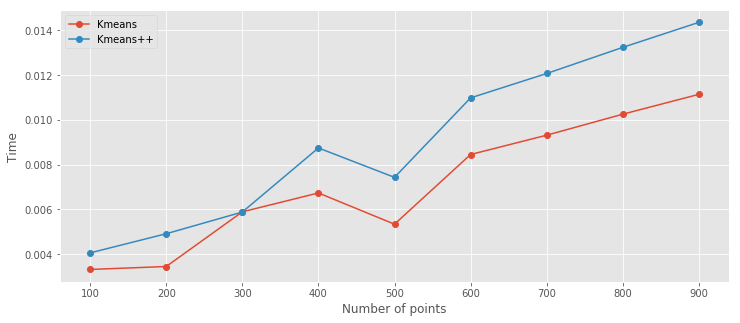

In [149]:
plt.plot(size, measure_k, marker = 'o', label = 'Kmeans')
plt.plot(size, measure_kpp, marker = 'o', label = 'Kmeans++')
plt.legend()
plt.axes().set_xlabel("Number of points")
plt.axes().set_ylabel("Time")

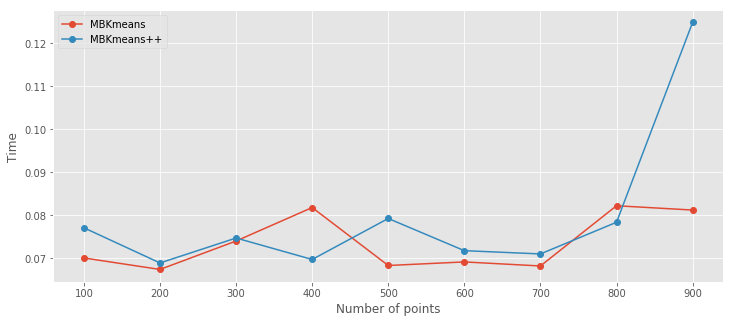

In [150]:
plt.plot(size, measure_mb, marker = 'o', label = 'MBKmeans')
plt.plot(size, measure_mbpp, marker = 'o', label = 'MBKmeans++')
plt.legend()
plt.axes().set_xlabel("Number of points")
plt.axes().set_ylabel("Time")

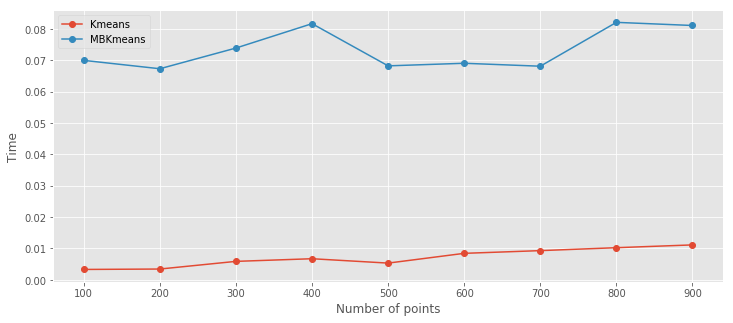

In [151]:
plt.plot(size, measure_k, marker = 'o', label = 'Kmeans')
plt.plot(size, measure_mb, marker = 'o', label = 'MBKmeans')
plt.legend()
plt.axes().set_xlabel("Number of points")
plt.axes().set_ylabel("Time")

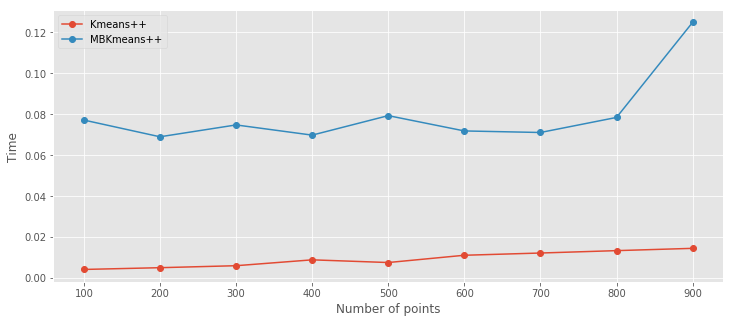

In [152]:
plt.plot(size, measure_kpp, marker = 'o', label = 'Kmeans++')
plt.plot(size, measure_mbpp, marker = 'o', label = 'MBKmeans++')
plt.legend()
plt.axes().set_xlabel("Number of points")
plt.axes().set_ylabel("Time")

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [90]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [91]:
df=df_sns.drop(['gradyear','gender','age','friends'],axis=1)

In [92]:
df.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [93]:
df=df.values
df=(df-df.mean(axis=0))/df.std(axis=0)

In [119]:
## KMeans
model_k = Kmeans(9, init='random')
model_k.fit(df,y=None)

Kmeans(init='random', k=9, max_iter=1000, metric='euclidean',
    random_state=None)

In [120]:
df_sns.loc [:, 'Kmeans'] = model_k.labels
df_sns.groupby('Kmeans') ['age'].aggregate (['count']).join (df_sns.groupby('Kmeans').aggregate
(['mean']))

,count,"(gradyear, mean)","(age, mean)","(friends, mean)","(basketball, mean)","(football, mean)","(soccer, mean)","(softball, mean)","(volleyball, mean)","(swimming, mean)",...,"(clothes, mean)","(hollister, mean)","(abercrombie, mean)","(die, mean)","(death, mean)","(drunk, mean)","(drugs, mean)","(Kmeans++, mean)","(MBKmeans, mean)","(MBKmeans++, mean)"
Kmeans,,,,,,,,,,,,,,,,,,,,,
0,1702,2007.689325,17.759129,32.236657,1.188822,1.490937,1.467271,0.154079,0.114300,0.163142,...,0.128399,0.036757,0.017120,0.152568,0.090634,0.063948,0.033233,3.137462,4.404834,3.680262
1,393,2007.322851,18.996557,35.287212,0.339623,0.276730,0.199161,0.119497,0.113208,0.184486,...,0.157233,0.033543,0.020964,0.348008,0.266247,0.109015,0.085954,6.645702,1.041929,3.035639
2,653,2007.344415,18.048331,33.136968,0.175532,0.268617,0.126330,0.107713,0.046543,0.162234,...,0.132979,0.011968,0.010638,0.167553,0.117021,0.054521,0.031915,5.422872,3.394947,3.611702
3,575,2007.762931,17.592021,36.933908,0.603448,0.357759,0.284483,0.308908,3.311782,0.191092,...,0.146552,0.051724,0.041667,0.122126,0.104885,0.064655,0.020115,1.985632,6.897989,3.119253
4,795,2007.612798,17.624238,30.672451,0.546638,0.505423,0.329718,0.194143,0.196312,0.275488,...,0.707158,0.132321,0.130152,1.300434,0.536876,0.836226,1.060738,3.147505,5.149675,3.380694
5,15903,2007.430481,18.181268,27.364996,0.132511,0.101876,0.103110,0.058083,0.040555,0.080802,...,0.050732,0.014701,0.008995,0.123362,0.078540,0.051041,0.020920,3.992033,3.738371,0.473657
6,411,2007.693582,17.528399,40.699793,0.770186,0.368530,0.196687,4.743271,0.383023,0.186335,...,0.225673,0.066253,0.053830,0.173913,0.142857,0.074534,0.057971,1.101449,3.954451,3.480331
7,715,2007.851190,17.489884,41.254762,0.372619,0.391667,0.295238,0.146429,0.189286,0.260714,...,0.420238,1.516667,1.170238,0.220238,0.155952,0.110714,0.075000,3.042857,7.857143,7.816667
8,3767,2007.614491,17.481069,36.210298,0.268398,0.243791,0.165869,0.103440,0.081795,0.280246,...,0.415129,0.056505,0.034176,0.222146,0.167692,0.109592,0.043746,0.525404,2.757348,4.943495


In [121]:
## KMeans++
model_kpp = Kmeans(9, init='++')
model_kpp.fit(df,y=None)

Kmeans(init='++', k=9, max_iter=1000, metric='euclidean', random_state=None)

In [122]:
df_sns.loc [:, 'Kmeans++'] = model_kpp.labels
df_sns.groupby('Kmeans++') ['age'].aggregate (['count']).join (df_sns.groupby('Kmeans++').aggregate
(['mean']))

,count,"(gradyear, mean)","(age, mean)","(friends, mean)","(basketball, mean)","(football, mean)","(soccer, mean)","(softball, mean)","(volleyball, mean)","(swimming, mean)",...,"(clothes, mean)","(hollister, mean)","(abercrombie, mean)","(die, mean)","(death, mean)","(drunk, mean)","(drugs, mean)","(Kmeans, mean)","(MBKmeans, mean)","(MBKmeans++, mean)"
Kmeans++,,,,,,,,,,,,,,,,,,,,,
0,1013,2007.507185,17.809429,31.025359,0.320372,0.299239,0.247675,0.158073,0.147929,0.191885,...,0.474218,0.046492,0.046492,1.095520,0.459848,0.930685,0.860524,4.706678,5.067625,4.598478
1,680,2007.365729,18.005318,32.992327,0.172634,0.274936,0.157289,0.117647,0.088235,0.154731,...,0.150895,0.010230,0.010230,0.172634,0.122762,0.051151,0.034527,2.092072,3.441176,3.634271
2,2030,2007.723919,17.382750,35.115352,1.397795,1.112383,0.638677,1.093723,0.845632,0.180237,...,0.149703,0.032231,0.022053,0.134860,0.100509,0.043257,0.023749,2.055556,4.670908,3.580153
3,545,2007.719875,17.182993,39.078247,0.402191,0.502347,0.231612,0.215962,0.183099,0.164319,...,0.201878,0.115806,0.073552,0.151800,0.120501,0.070423,0.046948,5.906103,3.460094,3.410016
4,3500,2007.620909,17.616124,36.273815,0.242062,0.267953,0.303859,0.106009,0.115779,0.294333,...,0.402540,0.056668,0.033708,0.209331,0.147044,0.064240,0.024426,7.476551,2.785051,4.890327
5,174,2007.653061,17.701753,29.413265,1.066327,1.056122,0.586735,0.505102,0.224490,0.423469,...,1.193878,0.474490,0.438776,1.520408,0.775510,1.000000,0.959184,4.081633,3.867347,1.285714
6,712,2007.846523,17.495715,41.044365,0.383693,0.378897,0.315348,0.164269,0.254197,0.258993,...,0.404077,1.507194,1.152278,0.213429,0.155875,0.104317,0.064748,6.872902,7.845324,7.808153
7,15947,2007.431694,18.197689,27.293238,0.117674,0.119414,0.148232,0.056764,0.059630,0.080923,...,0.052004,0.014741,0.009213,0.113068,0.076112,0.039310,0.015509,4.891130,3.770589,0.465117
8,313,2007.363395,19.082879,35.488064,0.355438,0.273210,0.251989,0.161804,0.116711,0.183024,...,0.156499,0.034483,0.021220,0.358090,0.270557,0.098143,0.098143,1.055703,1.084881,3.037135


In [123]:
## KMeans с MiniBatchKMeans
model_mb = MiniBatchKMeans(9, init='random',batch_size=1000)
model_mb.fit(df,y=None)

MiniBatchKMeans(batch_size=1000, init='random', k=9, max_iter=1000,
        metric='euclidean', random_state=None)

In [124]:
df_sns.loc [:, 'MBKmeans'] = model_mb.labels
df_sns.groupby('MBKmeans') ['age'].aggregate (['count']).join (df_sns.groupby('MBKmeans').aggregate
(['mean']))

,count,"(gradyear, mean)","(age, mean)","(friends, mean)","(basketball, mean)","(football, mean)","(soccer, mean)","(softball, mean)","(volleyball, mean)","(swimming, mean)",...,"(clothes, mean)","(hollister, mean)","(abercrombie, mean)","(die, mean)","(death, mean)","(drunk, mean)","(drugs, mean)","(Kmeans, mean)","(Kmeans++, mean)","(MBKmeans++, mean)"
MBKmeans,,,,,,,,,,,,,,,,,,,,,
0,2850,2007.600060,17.424080,36.576819,0.249925,0.271959,0.300332,0.122849,0.083912,0.306671,...,0.434651,0.065198,0.034410,0.159674,0.051917,0.079384,0.027769,7.384546,3.965288,4.661938
1,701,2007.755981,17.393241,36.038278,0.277512,0.239234,0.257177,0.149522,0.114833,0.132775,...,0.241627,0.046651,0.025120,0.228469,0.086124,0.169856,0.061005,6.500000,4.331340,4.076555
2,1278,2007.470946,18.168793,32.281757,0.227027,0.247973,0.201351,0.122297,0.062162,0.190541,...,0.239189,0.024324,0.024324,0.870270,0.150000,0.484459,0.512162,3.392568,2.738514,4.209459
3,719,2007.853601,17.480129,41.310508,0.395514,0.397875,0.318772,0.206612,0.187721,0.260921,...,0.404959,1.501771,1.165289,0.219599,0.142857,0.109799,0.074380,6.894923,5.854782,7.789847
4,2055,2007.665968,17.761701,34.140821,1.391869,1.325650,0.606454,0.888935,0.147108,0.152137,...,0.135792,0.031433,0.014669,0.131601,0.060352,0.049455,0.026823,1.894803,2.922464,3.476111
5,14803,2007.423305,18.171650,27.103598,0.101232,0.094960,0.148217,0.061235,0.039558,0.082691,...,0.054247,0.014800,0.009518,0.099692,0.000000,0.041923,0.015625,4.959892,6.760288,0.483990
6,582,2007.770000,17.566333,36.982857,0.618571,0.368571,0.308571,0.495714,3.368571,0.201429,...,0.160000,0.054286,0.042857,0.130000,0.081429,0.057143,0.030000,3.091429,3.645714,3.111429
7,385,2007.626932,17.858722,29.379691,0.856512,0.772627,0.538631,0.392936,0.253863,0.381898,...,1.037528,0.236203,0.227373,1.167770,0.520971,0.759382,0.883002,3.920530,2.412804,1.788079
8,1541,2007.472084,18.213886,32.071863,0.169707,0.147595,0.168049,0.104478,0.069652,0.122720,...,0.123825,0.024323,0.019900,0.322278,1.328358,0.088447,0.044223,5.279160,5.686567,2.299613


In [125]:
## KMeans++ с MiniBatchKMeans
model_mbpp = MiniBatchKMeans(9, init='++',batch_size=1000)
model_mbpp.fit(df,y=None)

MiniBatchKMeans(batch_size=1000, init='++', k=9, max_iter=1000,
        metric='euclidean', random_state=None)

In [126]:
df_sns.loc [:, 'MBKmeans++'] = model_mbpp.labels
df_sns.groupby('MBKmeans++') ['age'].aggregate (['count']).join (df_sns.groupby('MBKmeans++').aggregate
(['mean']))

,count,"(gradyear, mean)","(age, mean)","(friends, mean)","(basketball, mean)","(football, mean)","(soccer, mean)","(softball, mean)","(volleyball, mean)","(swimming, mean)",...,"(clothes, mean)","(hollister, mean)","(abercrombie, mean)","(die, mean)","(death, mean)","(drunk, mean)","(drugs, mean)","(Kmeans, mean)","(Kmeans++, mean)","(MBKmeans, mean)"
MBKmeans++,,,,,,,,,,,,,,,,,,,,,
0,1634,2007.435680,18.232517,31.480148,0.179460,0.238221,0.195871,0.096347,0.078878,0.179989,...,0.135521,0.011117,0.015352,0.254632,0.280042,0.060349,0.040762,3.920064,3.623081,4.203812
1,462,2007.798923,17.176247,35.962298,0.394973,0.380610,0.342908,0.236984,0.206463,0.222621,...,0.314183,0.087971,0.070018,0.201077,0.122083,0.120287,0.055655,6.689408,4.201077,2.538600
2,586,2007.670073,17.484925,33.750365,0.315328,0.321168,0.176642,0.135766,0.118248,0.150365,...,0.256934,0.051095,0.058394,0.258394,0.148905,0.109489,0.045255,6.947445,4.217518,2.173723
3,480,2007.222426,17.890156,34.977941,0.375000,0.380515,0.253676,0.238971,0.204044,0.154412,...,0.306985,0.082721,0.053309,0.222426,0.126838,0.090074,0.056985,6.915441,3.851103,1.446691
4,701,2007.853189,17.524078,41.101083,0.394705,0.398315,0.311673,0.216606,0.274368,0.253911,...,0.421179,1.512635,1.179302,0.216606,0.161252,0.111913,0.080626,6.844765,5.872443,3.104693
5,3682,2007.723977,17.313369,37.422690,0.825497,0.685614,0.585731,0.557895,0.513918,0.304327,...,0.337778,0.064094,0.028304,0.164211,0.131228,0.078363,0.033450,5.004678,3.306199,2.587135
6,472,2007.338624,18.895013,36.107584,0.338624,0.287478,0.243386,0.181658,0.125220,0.176367,...,0.178131,0.029982,0.017637,0.345679,0.252205,0.093474,0.070547,1.904762,6.828924,2.548501
7,810,2007.585547,17.641398,29.946865,0.533475,0.489904,0.330499,0.292242,0.209352,0.270988,...,0.679065,0.113709,0.113709,1.268863,0.490967,0.892667,1.085016,4.104145,1.063762,4.414453
8,16087,2007.436558,18.182401,27.444067,0.126325,0.131602,0.134493,0.068794,0.058089,0.076810,...,0.058191,0.014763,0.009132,0.119730,0.068946,0.051393,0.018873,4.933540,6.671148,4.958348


Посмотрим на степень схожести кластеров

In [127]:
import sklearn.metrics
print sklearn.metrics.cluster.adjusted_rand_score(model_k.labels, model_kpp.labels)
print sklearn.metrics.cluster.adjusted_rand_score(model_mb.labels, model_mbpp.labels)
print sklearn.metrics.cluster.adjusted_rand_score(model_k.labels, model_mb.labels)
print sklearn.metrics.cluster.adjusted_rand_score(model_kpp.labels, model_mbpp.labels)

0.83796564247
0.575103219343
0.686657434861
0.693644909321


Проинтерпретируем кластеры. Для этого возьмем результаты k-means.

Cluster 0
Students = 468, Age = 17.9289358974, friends=34.9981273408


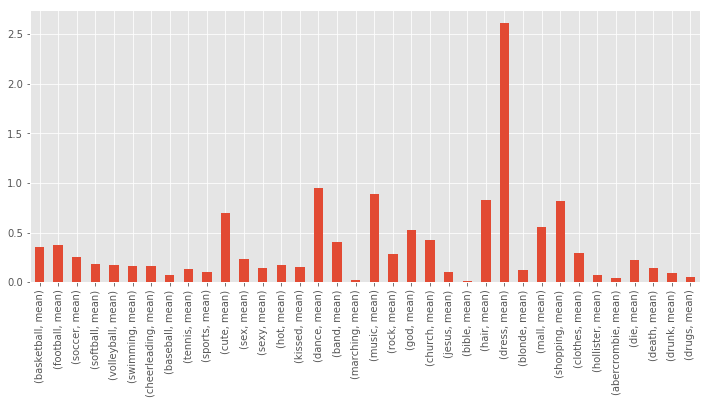

Cluster 1
Students = 708, Age = 17.5014929379, friends=40.9087635054


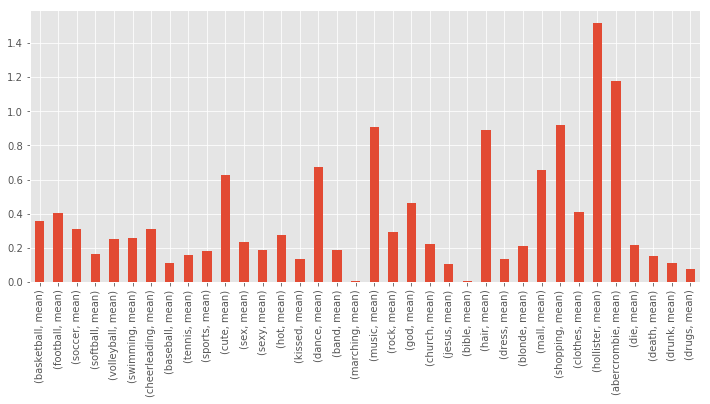

Cluster 2
Students = 359, Age = 19.142448468, friends=35.1207289294


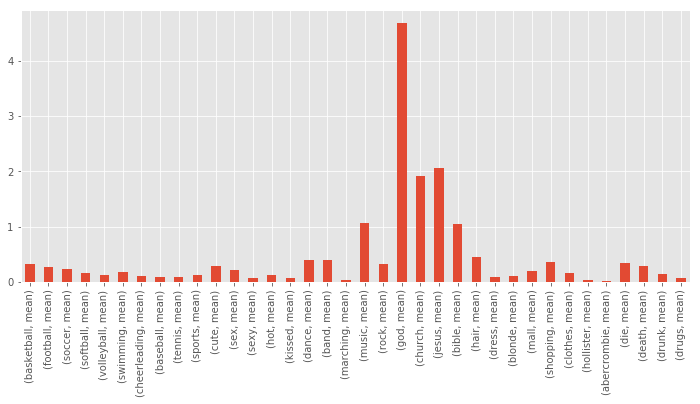

Cluster 3
Students = 1797, Age = 17.389902059, friends=35.3980906921


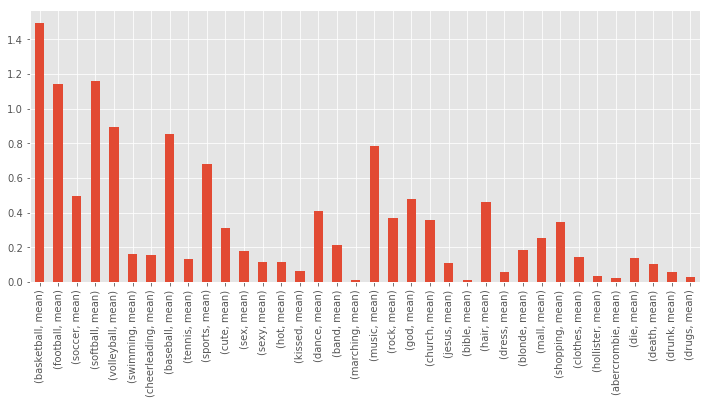

Cluster 4
Students = 3817, Age = 17.6423400576, friends=36.0461676378


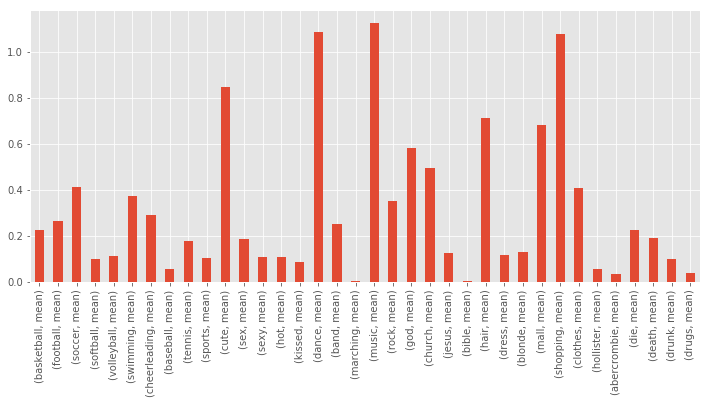

Cluster 5
Students = 15406, Age = 18.1971988186, friends=27.0960050864


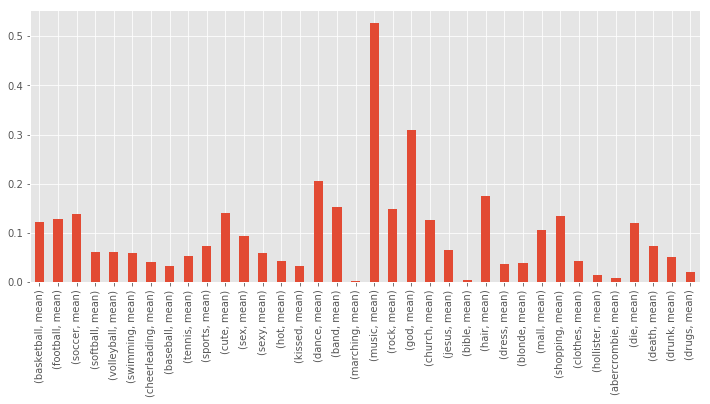

Cluster 6
Students = 749, Age = 17.6423271028, friends=30.1397228637


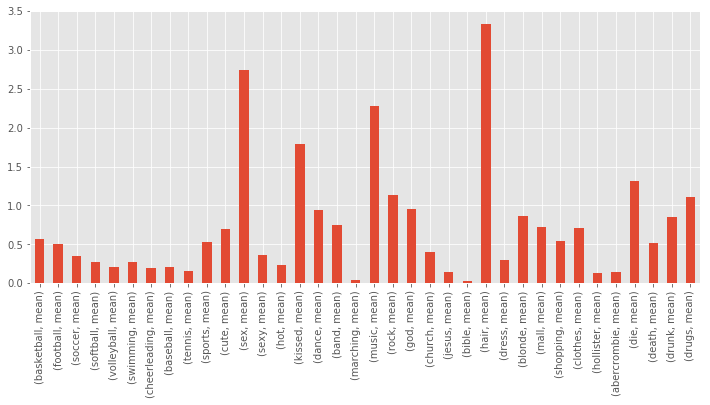

Cluster 7
Students = 959, Age = 17.4633910323, friends=34.8602430556


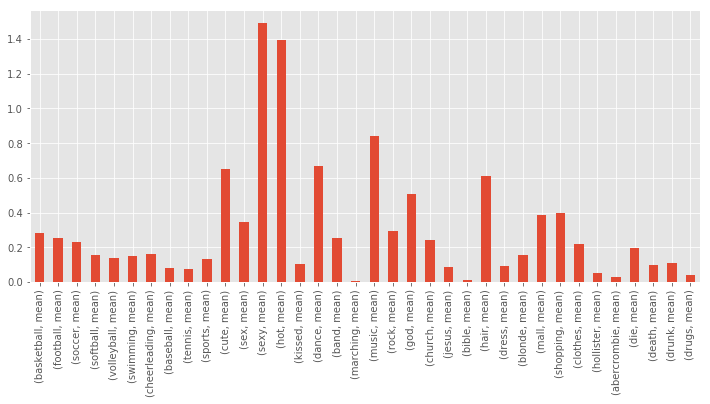

Cluster 8
Students = 651, Age = 18.0481029186, friends=32.9302013423


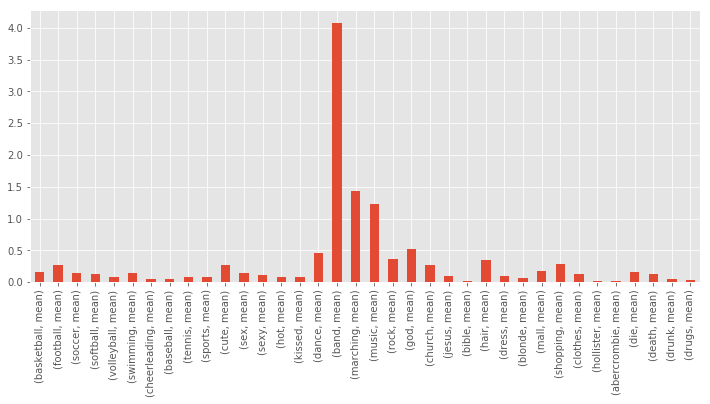

In [440]:
df_sns.loc [:, 'Kmeans'] = model_k.labels
interpretation = df_sns.groupby('Kmeans++') ['age'].aggregate (['count']).join(df_sns.groupby('Kmeans++').
                                                                               aggregate (['mean']))
for i in xrange(0, 9):
    print "Cluster {}".format(i)
    print "Students = {0}, Age = {1}, friends={2}".format (interpretation.iloc[i,0],
                                                                              interpretation.iloc[i,2],
                                                                              interpretation.iloc[i,3])
    interpretation.iloc[i, 4:40].plot.bar()
    plt.show()

## Вывод
Алгоритмы с "++" инициализацией работают медленнее при малом числе точек за счет долгого выбора началных(около 100 точек), но при увеличении числа точек могут сработать быстрее, если нам повезло с выбором начальных. Точность MiniBatchKmeans хуже, чем у KMeans, по скорости MiniBatch может оказаться быстрее при удачном выборе батчей и количестве итараций (вообще зависит от задачи). У MiniBatchKMeans есть довольно существеный недостаток: из-за того, что точки выбираются в нем случайно, может потребоваться много итераций, чтобы для всех точек найти ближайщий кластер. Недостатком всех алгоритмов является случайная инициализация. На примере (график с явными тремя кластерами) в некоторых случаях не везет, и 2 точки попадают изначально в один кластер, в результате получается совершенно не тот результат, который хотелось бы увидеть. 

В итоге: если важна точность, то KMeans++, если скорость - MiniBatchKMeans++.